1. В коде из методички реализуйте один или несколько критериев останова: количество листьев, количество используемых признаков, глубина дерева и т. д.

In [88]:
import matplotlib.pyplot as plt
import random
import time

import numpy as np
import pandas as pd

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_circles, make_regression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import train_test_split


In [89]:
classification_data, classification_labels = make_classification(n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=5)

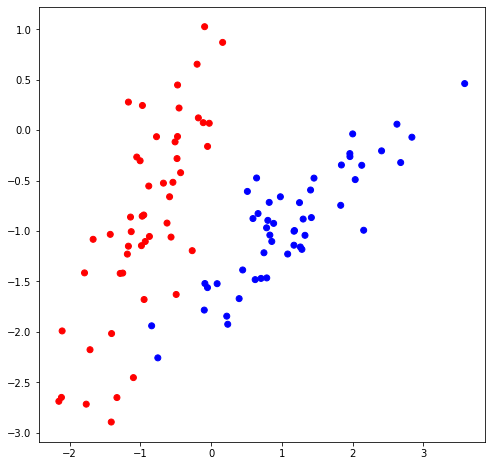

In [90]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [91]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [92]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [93]:
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [94]:
def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [95]:
def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [96]:
# Реализовала критерий останова: количество используемых признаков

In [97]:
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 3

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        if index > 0:
            continue
            
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 3 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [98]:
def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)

#     print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_labels)
    
#     print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [99]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [100]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [101]:

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [102]:
my_tree = build_tree(train_data, train_labels)

In [103]:
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print(spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print(spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0 <= 0.16261402870113306
--> True:
  Индекс 0 <= -0.11161924805848533
  --> True:
    Индекс 0 <= -0.8725985883473684
    --> True:
      Прогноз: 0
    --> False:
      Индекс 0 <= -0.5874922582052893
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 0
  --> False:
    Индекс 0 <= -0.05163250299323496
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 0
--> False:
  Прогноз: 1


In [104]:
train_answers = predict(train_data, my_tree)

In [105]:
answers = predict(test_data, my_tree)

In [106]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [107]:
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

95.71428571428572

In [108]:
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

96.66666666666667

In [109]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

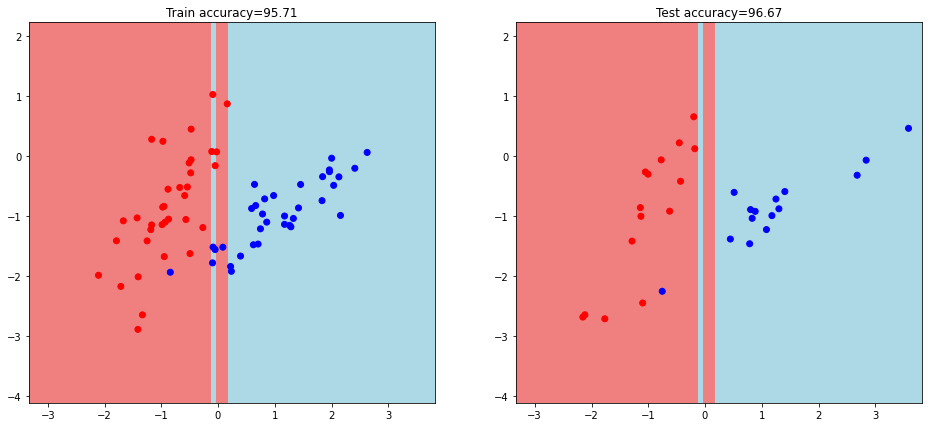

In [110]:
visualize(train_data, test_data)

2. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.


In [111]:
data, targets = make_regression(n_features=2, n_informative=2, random_state=5)

In [112]:
train_data_regr, test_data_regr, train_target_regr, test_target_regr = train_test_split(data, targets, test_size=0.3, random_state=1)

In [113]:
class Leaf:
    
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        self.prediction = self.predict()
        
    def predict(self):
        return np.mean(self.targets)              

In [114]:
def mse(targets):
    return np.mean((targets - np.mean(targets)) ** 2)

In [115]:
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 3

    root_mse = mse(targets)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
                    
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 3 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_labels, false_labels, root_mse)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [116]:
def build_tree(data, target):

    gain, t, index = find_best_split(data, target)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, target)
    
    true_data, false_data, true_target, false_target = split(data, target, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_target)

    false_branch = build_tree(false_data, false_target)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [117]:
my_tree = build_tree(train_data_regr, train_target_regr)
print_tree(my_tree)

Индекс 0 <= -1.4219245490984462
--> True:
  Прогноз: -133.16917969924597
--> False:
  Индекс 0 <= -1.167278449710173
  --> True:
    Прогноз: -109.61211729623078
  --> False:
    Индекс 0 <= -0.8241234534171207
    --> True:
      Прогноз: -68.85498102256815
    --> False:
      Индекс 0 <= -0.7111632283050703
      --> True:
        Прогноз: -49.07760116380869
      --> False:
        Индекс 0 <= -0.6315716297922155
        --> True:
          Прогноз: -56.60188133151829
        --> False:
          Индекс 0 <= -0.17170904843929477
          --> True:
            Индекс 0 <= -0.5017555471945
            --> True:
              Прогноз: -41.790238917944514
            --> False:
              Индекс 0 <= -0.47773141727821256
              --> True:
                Прогноз: -35.072442626305104
              --> False:
                Индекс 0 <= -0.28143012121166766
                --> True:
                  Прогноз: -3.996712215515457
                --> False:
                  Прогн

In [118]:
train_answers = predict(train_data_regr, my_tree)
r2_score(train_target_regr, train_answers)

0.9356095834619033

In [119]:
answers = predict(test_data_regr, my_tree)
r2_score(test_target_regr, answers)

0.7522849952301068